#Code

In [1]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
%matplotlib inline
from scipy.stats import norm
from numpy.random import  beta
import numpy as np
from statsmodels.stats.power import tt_ind_solve_power
from numpy.random import dirichlet

def query_db(host,query, params):
    conn = pymysql.connect(host =host, read_default_file="/etc/mysql/conf.d/analytics-research-client.cnf")
    cursor = conn.cursor(pymysql.cursors.DictCursor)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    conn.close()
    return mysql_to_pandas(rows)


def mysql_to_pandas(dicts):
    dmaster = {}
    for d in dicts:
        for k in d.keys():
            if k not in dmaster:
                dmaster[k] = []
            
            dmaster[k].append(d[k]) 
    return pd.DataFrame(dmaster)

def decode(x):
    try:
         return x.decode('utf-8')
    except:
        return x


def get_uname(uid):
    query = "SELECT gu_name from centralauth.globaluser where gu_id = %(id)s"
    try:
        return query_db( 'analytics-store.eqiad.wmnet', query,  {'id': uid  })['gu_name'][0]
    except:
        return None
    

def get_recs_df():
    rec_file = "/home/ellery/en-fr/final/frwiki-personal-recs.json"
    f = open(rec_file)
    recs = json.load(f)
    tuples = []
    for obj in recs:
        user = obj['user']
        for rec in obj['recommendations']:
            title = rec['title'].replace('_', ' ')
            score = rec['score']
            tuples.append((user, title, 'personal', score), )

    rec_file = "/home/ellery/en-fr/final/frwiki-random-recs.json"
    f = open(rec_file)
    recs = json.load(f)
    for obj in recs:
        user = obj['user']
        for rec in obj['recommendations']:
            title = rec['title'].replace('_', ' ')
            score = rec['score']
            tuples.append((user, title, 'random', score))


    d_recs = pd.DataFrame(tuples)
    d_recs.columns = ['user', 'translation_source_title', 'condition', 'affinity']
    return d_recs

def custom_rate_stats(a_num_events, a_num_trials, b_num_events, b_num_trials, alabel = 'A', blabel = 'B', conf=95, plot =True):
    a_dist = get_beta_dist(a_num_events, a_num_trials)
    b_dist = get_beta_dist(b_num_events, b_num_trials)
    d = pd.DataFrame.from_dict({alabel:a_dist, blabel:b_dist})
    return print_rate_stats(d, conf, plot)

def print_rate_stats(dists, conf, plot):

    """
    Helper function to create a pandas datframe with rate statistics
    """

    if plot:
        plot_dist(dists)
    result_df = pd.DataFrame()

    def f(d):
        rci = bayesian_ci(d, conf)
        return "(%0.6f, %0.6f)" % (rci[0], rci[1])

    result_df['Confidence Interval'] = dists.apply(f)

    def f(d):
        return d.idxmax()
    best = dists.apply(f, axis=1)
    result_df['P(Winner)'] = best.value_counts() / best.shape[0]
    result_df = result_df.sort('P(Winner)', ascending=False)

    def f(d):
        ref_d = dists[result_df.index[0]]
        lift_ci = bayesian_ci(100.0 * ((ref_d - d) / d), conf)
        return "(%0.2f%%, %0.2f%%)" % (lift_ci[0], lift_ci[1])

    result_df['Winners Lift'] = dists.apply(f)

    return result_df[['P(Winner)', 'Winners Lift', 'Confidence Interval']]

def get_beta_dist(num_events, num_trials, num_samples = 50000):
    return beta(num_events+1, num_trials-num_events+1, num_samples)


def bayesian_ci(dist, conf):
    return (np.percentile(dist, (100.0 - conf)/2.0 ), np.percentile(dist, conf + (100.0 - conf)/2.0 ))

def plot_dist(dists):
    """
    Helper function to plot the probability distribution over
    the donation rates (bayesian formalism)
    """
    fig =  plt.figure(figsize=(13, 3))

    bins = 50
    for name in dists.columns:
        plt.hist(dists[name], bins=bins, alpha=0.6, label=name, normed=True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Activation Rate')
    plt.ylabel('Posterior Probablility Density')
    
    

from collections import Counter
def bihist(a, a_label, b, b_label):
    """
    This one only operates in 2 banners.
    It gives very nice histogramms of donation amounts
    """
    a_cntr = Counter(a)
    b_cntr = Counter(b)

    print (a_cntr)

    keys = [int(s) for s in set(a_cntr.keys()).union(b_cntr.keys())]
    keys.sort()

    a_values = [a_cntr.get(k, 0) for k in keys]
    b_values = [b_cntr.get(k, 0) for k in keys]


    fig, ax = plt.subplots()
    fig.set_size_inches(7, 4)

    ind = 2.5*np.arange(len(keys))  # the x locations for the groups
    width = 1.2       # the width of the bars

    a_rects = ax.bar(ind, a_values, align='center', facecolor ='yellow', edgecolor='gray', label =a_label)
    b_rects = ax.bar(ind+width, b_values, align='center', facecolor ='blue', edgecolor='gray', label =b_label)

    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(keys)
    ax.legend()


    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%d'%int(height),
                    ha='center', va='bottom')

    autolabel(a_rects)
    autolabel(b_rects)

    plt.show()

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


# Collect and Merge Data Sources

In [2]:
cx_df = query_db( 'x1-slave.eqiad.wmnet', "SELECT * FROM wikishared.cx_translations WHERE translation_started_by = translation_last_update_by  ", {})
cx_df['user'] =  cx_df['translation_last_update_by'].apply(lambda x: get_uname(int(x)))

OperationalError: (2003, "Can't connect to MySQL server on 'x1-slave.eqiad.wmnet' ([Errno 8] nodename nor servname provided, or not known)")

In [3]:
d_recs = get_recs_df()
d_recs = d_recs.merge(cx_df, how = 'left', on = ['user', 'translation_source_title'])
d_recs['started'] = d_recs['translation_id'].notnull()
d_recs['rank'] = d_recs.groupby('user')['affinity'].rank(ascending=False, method = 'first')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ellery/en-fr/final/frwiki-personal-recs.json'

In [4]:
d_recs['published'] = d_recs['translation_status'] == 'published'
d_recs['drafted'] = d_recs['translation_status'] == 'draft'
d_recs['deleted'] = d_recs['translation_status'] == 'deleted'

NameError: name 'd_recs' is not defined

In [220]:
d_recs['translation_target_title'] = d_recs['translation_target_title'].apply(lambda x: unicode(str(x), 'utf-8').replace(u' ', u'_'))

In [107]:
def get_user_stats(x):
    n_started = x['started'].sum()
    n_drafted = x['published'].sum()
    n_published = x['drafted'].sum()
    n_deleted = x['deleted'].sum()
    return pd.Series({'active': n_started>0, 'started':n_started, 'published':n_published,'drafted': n_drafted, 'deleted': n_deleted })
    
d_users = d_recs.groupby(by=['user', 'condition']).apply(lambda x: get_user_stats(x)).reset_index()

In [108]:
# Get Users Gender
gender_df_fr = query_db( 'analytics-store.eqiad.wmnet', "SELECT * FROM staging.leila_artrecom_user_gender", {})
gender_df_fr.columns = ['gender', 'email', 'userid', 'user']
gender_df_en = query_db( 'analytics-store.eqiad.wmnet', "SELECT * FROM staging.leila_artrecom_user_gender_en", {})
gender_df_en.columns = ['gender', 'email', 'userid', 'user']
gender_df = gender_df_fr.append(gender_df_en).drop_duplicates()d_users = d_users.merge(gender_df, on = 'user', how = 'left')

In [109]:
d_active_users = d_users[d_users['active']]
d_active_recs = d_recs[d_recs['started'] > 0]

### Investigate User Gender

In [256]:
d_users['gender'].value_counts()

male      4267
female     301
dtype: int64

In [257]:
d_active_users['gender'].value_counts()

male      162
female      9
dtype: int64

In [118]:
d_active_users.groupby(['gender', 'condition']).count()

user  active  deleted  drafted  published  started  email  \
gender condition                                                              
female personal      8       8        8        8          8        8      8   
       random        1       1        1        1          1        1      1   
male   personal    106     106      106      106        106      106    106   
       random       56      56       56       56         56       56     56   

                  userid  
gender condition          
female personal        8  
       random          1  
male   personal      106  
       random         56

### Investigate  Creation and Deletion Rates

In [221]:
time_params =\
{
    'start_date' : '20150611000000',
    'end_date' : '20150708000000'
}

In [248]:
query = """
SELECT log_title, log_page, log_timestamp
FROM frwiki.logging 
WHERE log_type = 'delete'
AND log_action = 'delete'
AND log_timestamp > %(start_date)s
AND log_timestamp < %(end_date)s
AND log_namespace = 0
"""

deleted_df = query_db('analytics-store.eqiad.wmnet',query , time_params)
deleted_df.columns = ['page_id', 'timestamp', 'title',]


In [249]:
deleted_df.shape

(7404, 3)

In [250]:
deleted_recs = d_recs.merge(deleted_df, how = 'inner', left_on = 'translation_target_title', right_on = 'title')
deleted_recs.shape

(14, 24)

In [246]:
# Articles that were created in the span of interest and have been deleted
query = """
SELECT ar_title, ar_page_id, ar_timestamp
FROM frwiki.archive
WHERE ar_parent_id = 0
AND ar_namespace = 0
AND ar_timestamp > %(start_date)s
AND ar_timestamp < %(end_date)s
"""
archived_df = query_db('analytics-store.eqiad.wmnet',query , time_params)


In [261]:
archived_df.shape

(3508, 3)

In [251]:
archived_recs = d_recs.merge(archived_df, how = 'inner', left_on = 'translation_target_title', right_on = 'ar_title')
archived_recs.shape

(14, 24)

In [252]:
# Articles that were created in the span of interest and still exist
query = """
SELECT rev_timestamp, rev_page, page_title
FROM frwiki.revision, frwiki.page
WHERE rev_page = page_id
AND page_namespace = 0
AND page_is_redirect = 0
AND rev_parent_id = 0
AND rev_timestamp > %(start_date)s
AND rev_timestamp < %(end_date)s
"""
creations_df = query_db('analytics-store.eqiad.wmnet', query, params)

In [254]:
creations_df.shape

(9368, 3)

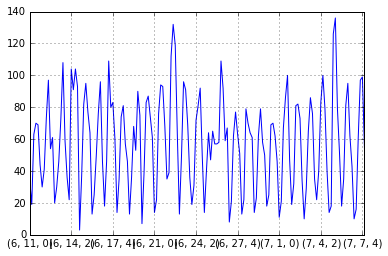

In [271]:
times = pd.DataFrame(index = pd.to_datetime(creations_df['rev_timestamp']))
times['n'] = 1
times.groupby(lambda x: ( x.month, x.day, x.hour / 4 )).sum()['n'].plot()

In [280]:
start_date = '20150611000000'
end_date = '20150625000000'

num_archived = archived_df[archived_df['ar_timestamp'] > start_date][archived_df['ar_timestamp'] < end_date].shape[0]
num_created = creations_df[creations_df['rev_timestamp'] > start_date][creations_df['rev_timestamp'] < end_date].shape[0]
base_rate = num_archived / float(num_created + num_archived)
print 'Baseline Deletion Rate: %f' % base_rate


rec_rate = float(deleted_recs.shape[0]) / d_active_recs[d_active_recs['translation_status'] == 'published'].shape[0]
print "Published Translation Deletion Rate %f" %  rec_rate



Baseline Deletion Rate: 0.308029
Published Translation Deletion Rate 0.085890


### Simple Stats

In [8]:
print "Number of translations started: ", d_active_recs.shape[0]

Number of translations started:  433


In [9]:
d_active_recs['translation_status'].value_counts()

draft        242
published    163
deleted       28
dtype: int64

In [22]:
d_active_recs[d_active_recs['translation_status'] == 'published']['condition'].value_counts()

personal    113
random       50
dtype: int64

In [10]:
print 'Number of personal translations:', (d_active_recs['condition'] == 'personal').sum()
print 'Number of random translations: ', (d_active_recs['condition'] == 'random').sum()

Number of personal translations: 278
Number of random translations:  155


In [11]:
print 'Number of personal editors activated: ', (d_active_users['condition'] == 'personal').sum()
print 'Number of random editors activated: ', (d_active_users['condition'] == 'random').sum()

Number of personal editors activated:  208
Number of random editors activated:  119


#Data Over time

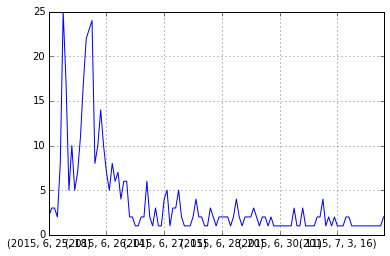

In [12]:
times = pd.DataFrame(index = pd.to_datetime(d_active_recs['translation_start_timestamp']))
times['n'] = 1
times.groupby(lambda x: (x.year, x.month, x.day, x.hour )).sum()['n'].plot()

# Num Started and Published per Editor by condition

Counter({1: 166, 2: 24, 3: 11, 4: 4, 5: 3})


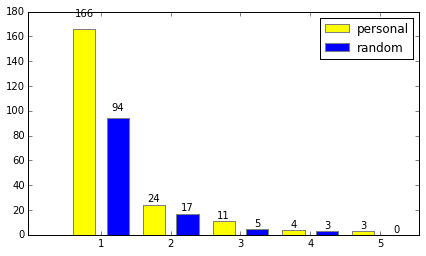

In [13]:
a = d_active_users[d_active_users['condition'] == 'random']['started']
b = d_active_users[d_active_users['condition'] == 'personal']['started']

bihist(b, 'personal', a, 'random' )

Counter({1: 105, 0: 85, 2: 13, 3: 4, 4: 1})


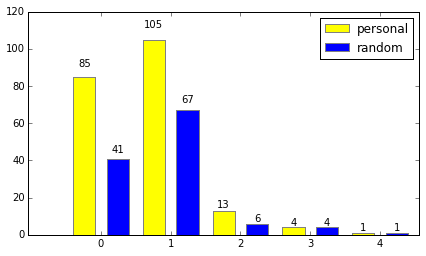

In [14]:
a = d_active_users[d_active_users['condition'] == 'random']['published']
b = d_active_users[d_active_users['condition'] == 'personal']['published']

bihist(b, 'personal', a, 'random' )

# Position of Started Objects 

Counter({1.0: 88, 4.0: 61, 5.0: 47, 2.0: 45, 3.0: 37})


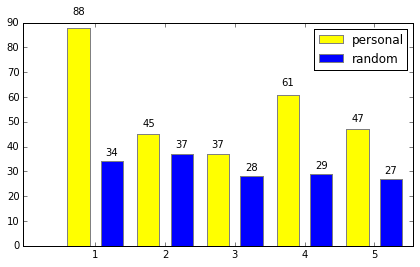

In [15]:
a = d_active_recs[d_active_recs['condition'] == 'random']['rank']
b = d_active_recs[d_active_recs['condition'] == 'personal']['rank']

bihist(b, 'personal', a, 'random' )


# Activation as a Function of Affinity

(12040, 21)
(6011, 21)


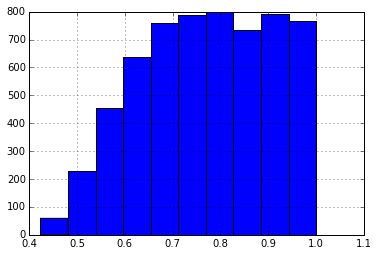

In [16]:
d_first_rec = d_recs.groupby('user').apply(lambda x: x.iloc[0])
print d_first_rec.shape
d_first_rec_personal = d_first_rec[d_first_rec['condition'] == 'personal']
print d_first_rec_personal.shape
d_first_rec_personal_active = d_first_rec_personal[d_first_rec_personal['started'] == 1]
d_first_rec_personal['affinity'].hist()

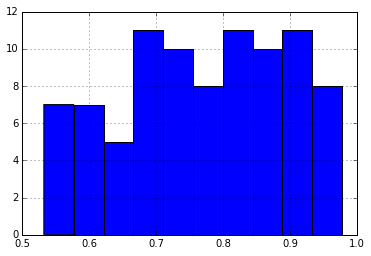

In [17]:
d_first_rec_personal_active['affinity'].hist()

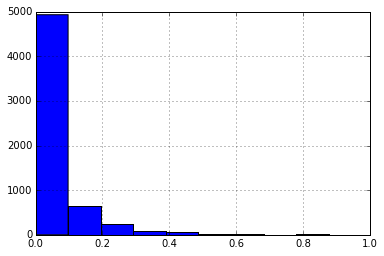

In [18]:
d_first_rec_random = d_first_rec[d_first_rec['condition'] == 'random']
d_first_rec_ransom_active = d_first_rec_random[d_first_rec_random['started'] == 1]
d_first_rec_random['affinity'].hist()

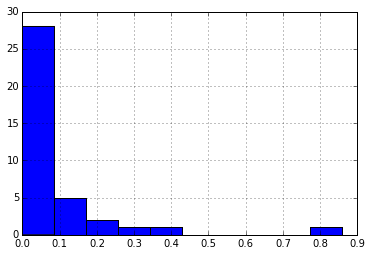

In [19]:
d_first_rec_ransom_active['affinity'].hist()

In [20]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
model = logistic.fit(X, y)

NameError: name 'model' is not defined

# Activation Rates By Group

,P(Winner),Winners Lift,Confidence Interval
Personal,1,"(0.00%, 0.00%)","(0.031529, 0.040582)"
Random,NaN,"(41.15%, 114.66%)","(0.017331, 0.024280)"


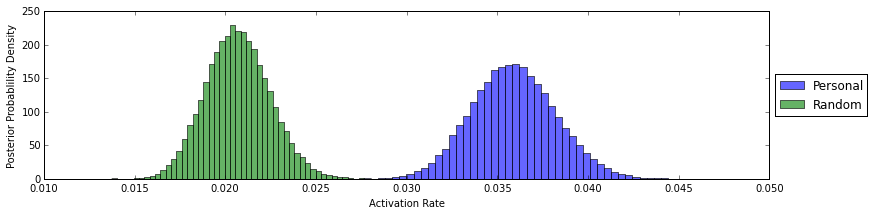

In [438]:

personal_num_events = (d_active_users['condition'] == 'personal').sum()
personal_num_trials = (d_users['condition'] == 'personal').sum()
random_num_events = (d_active_users['condition'] == 'random').sum()
random_num_trials = (d_users['condition'] == 'random').sum()


custom_rate_stats(personal_num_events, personal_num_trials, random_num_events, random_num_trials, alabel = 'Personal', blabel = 'Random', conf=95, plot =True)

# Explore Rates as a function of recency and bilingualism

In [131]:
b = pd.read_csv("/home/ellery/en-fr/bilingual_users.tsv", encoding = 'utf8', sep = '\t')
b = d_users.merge(b, how = 'inner', on = 'user')
b['active'].sum() - d_active_users.shape[0]
b['max_date'] = pd.to_datetime(b['max_date'])
b['months_since_last_edit'] = b['max_date'].apply(lambda x: (6 + 12*2015) - (x.month + 12*x.year))
b['byte_group'], byte_bins = pd.qcut( b['min_byte'], 5 , labels  = False, retbins = True)
#b['byte_group'] = b['min_byte'].apply(lambda x: min(x, 100) / 25)

bp = b[b['condition'] == 'personal']
br = b[b['condition'] == 'random']

In [132]:
byte_bins.astype(int)

array([    26,     87,    149,    994,   7530, 135669])

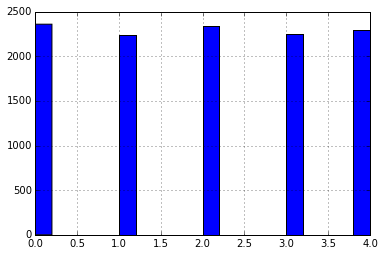

In [133]:
b['byte_group'].hist(bins = 20)

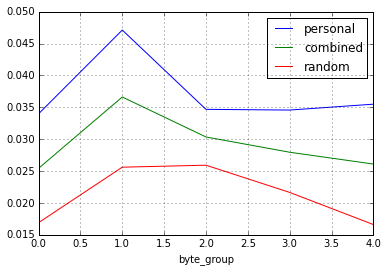

In [134]:
plt.figure()
bp.groupby('byte_group').apply(lambda x: x['active'].sum() / float(x.shape[0])).plot(label = 'personal')
b.groupby('byte_group').apply(lambda x: x['active'].sum() / float(x.shape[0])).plot(label = 'combined')
br.groupby('byte_group').apply(lambda x: x['active'].sum() / float(x.shape[0])).plot(label = 'random')
plt.legend()

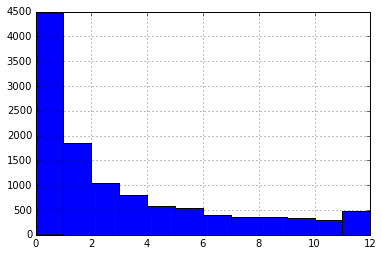

In [135]:
b['months_since_last_edit'].hist(bins = 12)

/home/ellery/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/home/ellery/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


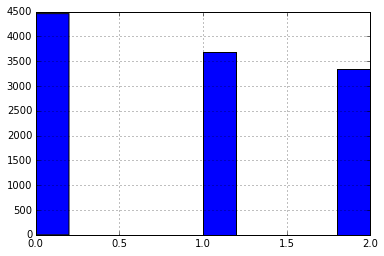

In [136]:
b['date_group'] = 0
b['date_group'][b['months_since_last_edit'] >= 1] = 1
b['date_group'][b['months_since_last_edit'] >= 4] = 2
#b['date_group'][b['months_since_last_edit'] >= 6] = 3
b['date_group'].hist()
bp = b[b['condition'] == 'personal']
br = b[b['condition'] == 'random']

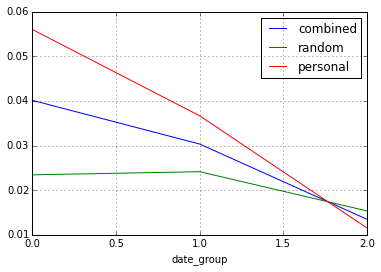

In [137]:
plt.figure()
b.groupby('date_group').apply(lambda x: x['active'].sum() / float(x.shape[0])).plot(label = 'combined')
br.groupby('date_group').apply(lambda x: x['active'].sum() / float(x.shape[0])).plot(label = 'random')
bp.groupby('date_group').apply(lambda x: x['active'].sum() / float(x.shape[0])).plot(label = 'personal')
plt.legend()

In [142]:
b.groupby( ['months_since_last_edit'])['active'].sum()

months_since_last_edit
0                         179
1                          70
2                          24
3                          18
4                          13
5                           5
6                           7
7                           4
8                           3
9                           6
10                          2
11                          2
12                          3
Name: active, dtype: float64

### Spill Over Engagement

In [412]:
exp_start = '2015060251000'

In [413]:
cx_user_start_times = pd.DataFrame(cx_df.groupby('user')['translation_start_timestamp'].min())
cx_user_start_times['user'] = cx_user_start_times.index

In [414]:
contacted_users = pd.DataFrame( index = d_users['user'].drop_duplicates())
contacted_users['first_cx_use'] = cx_user_start_times['translation_start_timestamp']

In [415]:
contacted_users['cx_user_status']  = 'not a user'

In [416]:
# Newbie: A user we contacted who had their first cx interaction after thr email
# Veteran: A user we contacted who had used cx before
contacted_users['cx_user_status'][contacted_users['first_cx_use'] > exp_start] = 'newbie'
contacted_users['cx_user_status'][contacted_users['first_cx_use'] <= exp_start] = 'veteran'

In [417]:
print contacted_users['cx_user_status'].value_counts()
print contacted_users['cx_user_status'].shape[0]

not a user    10966
newbie          609
veteran         465
dtype: int64
12040


In [418]:
cx_aug = cx_df.merge(contacted_users, how = 'left', left_on = 'user', right_index = True)
cx_aug['cx_user_status'].fillna('not contacted', inplace = True)
cx_aug = cx_aug[cx_aug['translation_status'] == 'published']

In [419]:
# Published Article counts by whether the author was contacted
cx_aug['cx_user_status'].value_counts()

not contacted    5683
veteran          1408
newbie            400
dtype: int64

In [420]:
# Published Article counts by whether the article was recommended 
cx_aug = cx_aug.merge(d_recs[['condition', 'translation_id']], how = 'left', on = 'translation_id')
cx_aug['condition'].fillna('not recommended', inplace = True)

In [421]:
cx_aug['condition'].value_counts()

not recommended    7328
personal            113
random               50
dtype: int64

In [422]:
# Did published recs come from Vets or Newbies 
cx_aug[cx_aug['condition'] != 'not recommended']['cx_user_status'].value_counts()

newbie     149
veteran     14
dtype: int64

In [423]:
# What condition where the newbie publications in
cx_aug[cx_aug['cx_user_status'] == 'newbie']['condition'].value_counts()

not recommended    251
personal           102
random              47
dtype: int64

In [424]:
# How many of these Non Recommended Publications from newbie users came from users who also responded to a rec?
cx_aug = cx_aug.merge(d_users[['user', 'active']].drop_duplicates(), on = 'user', how = 'left')

In [425]:
cx_aug[cx_aug['active'] == True][cx_aug['cx_user_status'] == 'newbie']['condition'].value_counts()

personal           102
random              47
not recommended     28
dtype: int64

In [439]:
cx_aug.columns

Index([u'translation_id', u'translation_last_update_by', u'translation_last_updated_timestamp', u'translation_progress', u'translation_source_language', u'translation_source_title', u'translation_source_url', u'translation_start_timestamp', u'translation_started_by', u'translation_status', u'translation_target_language', u'translation_target_title', u'translation_target_url', u'user', u'first_cx_use', u'cx_user_status', u'condition', u'active'], dtype='object')

In [441]:
#cx_aug[cx_aug['cx_user_status'] == 'newbie'][['user', 'translation_source_title']]

# Activation Rate Test

# Scratch

In [145]:
rtuples = []
rec_file = "/home/ellery/en-fr/final/frwiki-random-recs.json"
f = open(rec_file)
recs = json.load(f)
for obj in recs:
    user = obj['user']
    for rec in obj['recommendations']:
        title = rec['title'].replace('_', ' ')
        score = rec['score']
        rtuples.append((user, title, 'random', score))
        
        
        
        
dr = pd.DataFrame(tuples)



In [148]:
'Nbrouard' in set(dr[0])

True

In [164]:
d[d['user'] == 'Xavier Combelle']

,user,translation_source_title,condition,affinity
28830,Xavier Combelle,Mal du siècle,personal,0.488235
28831,Xavier Combelle,Acousmatic sound,personal,0.483887
28832,Xavier Combelle,Mécanisme de la physionomie humaine,personal,0.465202
28833,Xavier Combelle,Philosophy of love,personal,0.450705
28834,Xavier Combelle,Politician's syllogism,personal,0.432555


My questions:
0) baseline as random recommendations could actually be considered a negative (as in actively disruptive) treatment, how do we address this?
1) How many editors activated were existing translators? Can we say that recs brought a larger share of the editor population to CX?
2) Are we planning to look at sustained/repeated use of CX? Hypothesis: recs as an invitation to discover tool which people wouldn’t discover otherwise
3) Deletion rates compared to organic translations: do completed translations coming from recs survive at a higher rate?

Re. personalization, a better control might be a global mean.